In [1]:
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pl_bolts
from relative_performer.train import RelativePerformerModel
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/Users/hornm/Projects/RelativePerformer/notebooks'

In [3]:
dataset = pl_bolts.datamodules.MNISTDataModule('../data/MNIST')

In [4]:
train_loader = dataset.train_dataloader()
batch = next(train_loader.__iter__())

In [5]:
x, y = batch
x = x.permute(0, 2, 3, 1)
x = x[[0]]

In [6]:
x.shape

torch.Size([1, 28, 28, 1])

In [66]:
model = RelativePerformerModel(dim=128, heads=1, depth=1, in_features=1, max_pos=28, pos_dims=2, pos_scales=8, num_classes=10, embedding_type='linear', no_projection=True)

In [67]:
x_flat, positions = model._flatten_to_sequence(x)

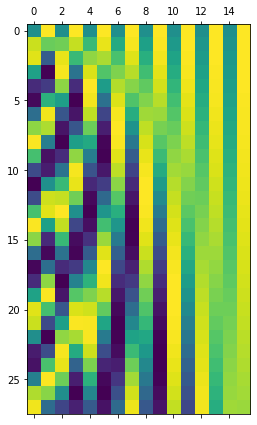

In [68]:
plt.matshow(model._compute_positional_embeddings(positions[:, :28, [1]]).detach().numpy()[0], aspect='auto')

In [95]:
out1 = model(x).detach().numpy()

In [102]:
out2 = model(x_flat, positions).detach().numpy()

In [97]:
out3 = model(x_flat, positions + torch.ones(*positions.shape)).detach().numpy()

In [103]:
np.allclose(out1, out2)

True

In [99]:
np.allclose(out1, out3)

True

In [100]:
out1[0], out3[0]

(array([-0.18364005,  0.40394008,  0.12559885,  1.212065  , -0.3024696 ,
        -0.23812824, -0.6652707 ,  0.00577746, -0.44367722, -0.1302074 ],
       dtype=float32),
 array([-0.18364005,  0.40394008,  0.12559885,  1.212065  , -0.3024696 ,
        -0.23812824, -0.6652707 ,  0.00577746, -0.44367722, -0.1302074 ],
       dtype=float32))

In [75]:
positions + torch.ones(*positions.shape)

tensor([[[ 1.,  1.],
         [ 1.,  2.],
         [ 1.,  3.],
         ...,
         [28., 26.],
         [28., 27.],
         [28., 28.]]])

In [76]:
projection_matrix = model.performer.net.layers[0][0].fn.to_q._build_positional_projection_matrix()
print(projection_matrix.shape)
# projection_matrix = projection_matrix[:, :32, :32]

torch.Size([1, 32, 32])


In [77]:
from einops import repeat
def compute_dot_prod(i1, i2, j1, j2):
    positions = torch.Tensor([[i1, i2], [j1, j2]])[None]
    from einops import rearrange
    encodings = model._compute_positional_embeddings(positions)
    k = repeat(encodings, 'b n d -> b h n d', h=1)
    encodings = rearrange(encodings, 'b n d -> b n 1 1 d')
    encodings = encodings.matmul(projection_matrix)
    encodings = rearrange(encodings, 'b n h 1 d -> b h n d')
    return encodings.matmul(k.transpose(-1, -2))
print(compute_dot_prod(0, 0, 1, 1))
print(compute_dot_prod(128, 127, 129, 128))

tensor([[[[-2.6894, -4.8353],
          [ 1.5564, -2.6894]]]], grad_fn=<UnsafeViewBackward>)
tensor([[[[-2.6894, -4.8353],
          [ 1.5564, -2.6894]]]], grad_fn=<UnsafeViewBackward>)


In [78]:
from relative_performer.constrained_relative_encoding import ConstrainedLinear, IdentityLinear

to_q, to_k = ConstrainedLinear(1, 2, 16, 2), IdentityLinear(1, 2, 16, 2)

In [90]:
to_q._build_positional_projection_matrix_test().shape

torch.Size([2, 16, 2, 2])

In [79]:
to_q._build_positional_projection_matrix_test()[0]

tensor([[[ 0.1380, -0.3112],
         [ 0.3112,  0.1380]],

        [[ 0.2101, -1.5771],
         [ 1.5771,  0.2101]],

        [[-0.9529, -0.9616],
         [ 0.9616, -0.9529]],

        [[-0.0875,  1.3311],
         [-1.3311, -0.0875]],

        [[ 1.1248,  2.2364],
         [-2.2364,  1.1248]],

        [[-0.9593, -0.4814],
         [ 0.4814, -0.9593]],

        [[ 0.9062,  0.4642],
         [-0.4642,  0.9062]],

        [[ 2.0007,  1.3315],
         [-1.3315,  2.0007]],

        [[-0.2575, -0.6542],
         [ 0.6542, -0.2575]],

        [[ 0.0039,  1.6808],
         [-1.6808,  0.0039]],

        [[-1.5500,  2.1098],
         [-2.1098, -1.5500]],

        [[-0.8114,  0.3042],
         [-0.3042, -0.8114]],

        [[ 0.6494, -0.1627],
         [ 0.1627,  0.6494]],

        [[ 0.4672, -0.1172],
         [ 0.1172,  0.4672]],

        [[ 0.9907, -1.9594],
         [ 1.9594,  0.9907]],

        [[-0.3136,  1.2583],
         [-1.2583, -0.3136]]], grad_fn=<SelectBackward>)

In [80]:
to_q._build_positional_projection_matrix()[0]

tensor([[ 0.1380, -0.3112,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3112,  0.1380,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.2101,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.9907,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3136,  1.2583],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.2583, -0.3136]],
       grad_fn=<SelectBackward>)

In [94]:
def compute_dot_prod(i1, i2, j1, j2):
    positions = torch.Tensor([[i1, i2], [j1, j2], [i1, i2]])[None]
    from einops import rearrange
    encodings = model._compute_positional_embeddings(positions)
    fake_data = torch.zeros(1, 3, 1)
    q = to_q(fake_data, encodings)
    k = to_k(fake_data, encodings)
    # print('q:', q[..., 1:])
    encodings = rearrange(encodings, 'b n d -> b n 1 1 d')
    encodings = encodings.matmul(to_q._build_positional_projection_matrix())
    encodings = rearrange(encodings, 'b n h 1 d -> b h n d')
    print(encodings)
    # print('encodings:', encodings)
    # return encodings.matmul(k[..., 1:].transpose(-1, -2))
    return q[..., 1:].matmul(k[..., 1:].transpose(-1, -2))

def compute_dot_prod2(i1, i2, j1, j2):
    positions = torch.Tensor([[i1, i2], [j1, j2], [i1, i2]])[None]
    from einops import rearrange
    encodings = model._compute_positional_embeddings(positions)
    fake_data = torch.zeros(1, 3, 1)
    q = to_q(fake_data, encodings)
    k = to_k(fake_data, encodings)
    # print('q:', q[..., 1:])
    encodings = rearrange(encodings, 'b n (s d) -> b 1 s n d', s=to_q.pos_scales, d=2)
    # Format batch_size, heads, scales, instances, 2
    print(encodings.shape)
    encodings = encodings.matmul(to_q._build_positional_projection_matrix_test())
    print(encodings.shape)
    encodings = rearrange(encodings, 'b h s n d -> b h n (s d)')
    print(encodings)
    # print('encodings:', encodings)
    # return encodings.matmul(k[..., 1:].transpose(-1, -2))
    print(q.shape, k.shape)
    return encodings.matmul(k[..., 1:].transpose(-1, -2))

print(compute_dot_prod(0, 0, 1, 1))
print(compute_dot_prod2(0, 0, 1, 1))

tensor([[[[ 0.3112,  0.1380,  1.5771,  0.2101,  0.9616, -0.9529, -1.3311,
           -0.0875, -2.2364,  1.1248,  0.4814, -0.9593, -0.4642,  0.9062,
           -1.3315,  2.0007,  0.6542, -0.2575, -1.6808,  0.0039, -2.1098,
           -1.5500, -0.3042, -0.8114,  0.1627,  0.6494,  0.1172,  0.4672,
            1.9594,  0.9907, -1.2583, -0.3136],
          [ 0.2843, -0.1873,  1.4170, -0.7236,  0.5574, -1.2336, -1.3179,
            0.2064, -2.0666,  1.4127,  0.4024, -0.9950, -0.4194,  0.9278,
           -1.2718,  2.0392,  0.1368, -0.6896, -1.3807,  0.9586, -2.5244,
           -0.6934, -0.4747, -0.7250,  0.2478,  0.6219,  0.1545,  0.4562,
            2.0054,  0.8938, -1.2671, -0.2763],
          [ 0.3112,  0.1380,  1.5771,  0.2101,  0.9616, -0.9529, -1.3311,
           -0.0875, -2.2364,  1.1248,  0.4814, -0.9593, -0.4642,  0.9062,
           -1.3315,  2.0007,  0.6542, -0.2575, -1.6808,  0.0039, -2.1098,
           -1.5500, -0.3042, -0.8114,  0.1627,  0.6494,  0.1172,  0.4672,
            1.95

torch.Size([1, 2, 64])
torch.Size([1, 2, 1, 1, 64]) torch.Size([1, 64, 64])


tensor([[[[-1.5903e-01,  4.0181e-01, -1.2574e-01, -8.3570e-01, -9.4050e-01,
           -9.1811e-01, -6.4195e-01, -4.6085e-01,  8.4565e-01, -6.2729e-01,
            1.0973e+00, -1.6743e-03, -2.0976e+00, -5.0637e-02, -7.9917e-01,
           -9.1657e-01,  6.4160e-01,  2.4675e-01, -3.6092e-01, -1.8101e-01,
            2.0272e+00, -2.6797e-01,  5.3959e-01, -3.0601e+00, -1.0257e+00,
           -1.5845e+00,  1.6931e+00,  3.0705e+00, -1.2546e+00,  1.1155e-01,
            4.0269e-02, -9.0187e-01,  1.1881e+00,  3.7918e-01,  4.0917e-02,
           -9.8124e-01, -1.3745e+00, -1.3507e+00,  8.1876e-01,  4.7793e-01,
           -1.2073e+00, -4.8846e-01,  1.2825e+00, -1.6561e+00,  7.4863e-02,
           -6.7758e-01,  5.5289e-01,  2.9380e-01, -3.9080e-02,  3.0735e-02,
            3.5005e-01, -2.8727e-01, -8.6605e-01,  8.1303e-01,  1.1111e+00,
           -2.2804e+00,  1.9332e+00,  4.1228e-01, -4.5921e-01, -1.2461e+00,
            5.7522e-01,  2.1921e+00, -8.8906e-01,  4.4382e-01,  9.4483e-02,
            

In [65]:
torch.matmul(q, k.transpose(-1, -2))

tensor([[[[[-1.2719,  1.1333,  0.0443,  ...,  0.6008,  0.1514, -0.0119]],

          [[-0.1083, -0.1909,  1.1390,  ...,  0.9228,  0.3081,  0.4741]],

          [[-0.8484, -0.1518, -0.9177,  ...,  0.4169,  0.0515, -0.9480]],

          [[-0.5884, -0.7237, -0.7027,  ..., -0.1708,  0.0792,  0.2196]]],


         [[[-1.2719,  1.1333,  0.0443,  ...,  0.6188,  0.1511, -0.0147]],

          [[-0.1083, -0.1909,  1.1390,  ...,  0.9085,  0.3168,  0.4683]],

          [[-0.8484, -0.1518, -0.9177,  ...,  0.4179,  0.0340, -0.9488]],

          [[-0.5884, -0.7237, -0.7027,  ..., -0.2246,  0.0833,  0.2181]]],


         [[[-1.2719,  1.1333,  0.0443,  ...,  0.6366,  0.1508, -0.0175]],

          [[-0.1083, -0.1909,  1.1390,  ...,  0.8938,  0.3254,  0.4624]],

          [[-0.8484, -0.1518, -0.9177,  ...,  0.4188,  0.0165, -0.9492]],

          [[-0.5884, -0.7237, -0.7027,  ..., -0.2784,  0.0873,  0.2165]]],


         ...,


         [[[ 1.4554,  0.8853,  1.9845,  ...,  0.9706,  0.1303, -0.0780]],

   

In [50]:
encodings[0, 0]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 